# Portfolio Selector

In [65]:
#### Imports ####
#################

### basics
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import copy


### yahoo finance
import yfinance as yf

### pandas
import pandas as pd
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix


### data optimization library
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage,risk_matrix
from pypfopt import plotting

In [168]:
### Functions 
def split_train_test(dataset,first,end):
   '''
    Divide data set in train and test. This will be useful to train our stocks along with our previous Risk tolerance, and then the test set will be used to perform backtests. 
    
    Arguments:
    dataset: (Dataframe) index:(Timestamp), cols:(float) stock price values
    first: ((list) shape=(3)) [(int) year,(int) month,(int) day]
    end:   ((list) shape=(3)) [(int) year,(int) month,(int) day]
    '''

    first = [str(f) for f in first]
    end = [str(e) for e in end]

    y_1,m_1,d_1 = first
    y_2,m_2,d_2 = end

    #### Corrijo el formato de int a str, ej si me dan el día 1 de enero de 2014, el input es [2014,1,1] pero el string es 2014-01-01
    if len(m_1) == 1:
        m_1 = "0"+m_1
    if len(m_2) == 1:
        m_2 = "0"+m_2
    if len(d_1) == 1:
        d_1 = "0"+d_1
    if len(d_2) == 1:
        d_2 = "0"+d_2

    dataset = dataset.set_index("Date")
    dates_times = dataset.index
    dates = [fulldate.split(" ")[0] for fulldate in dates_times]

    
    try:
        idx_1 =  dates.index(f"{y_1}-{m_1}-{d_1}")
    except:
        print("This date for Begin doesnt exist, try another")
        return

    try:
        idx_2 =  dates.index(f"{y_2}-{m_2}-{d_2}")
    except:
        print("This date for END doesnt exist, try another")
        return
    
    return dataset[idx_1:idx_2],dataset[idx_2:]


def porfolio_weights(mu,S,risk, plot = False):
    '''
    Porfololio weights so as to maximize return according to specific risk tolerance
    
    '''

    ef = EfficientFrontier(mu, S)

    volatility = risk2var(risk,S)
    weights = ef.efficient_risk(volatility)
    ef.portfolio_performance(verbose=True)


    if plot:
        w_k, w_v = [],[]
        for k in weights.keys():
            w_k.append(k)
            w_v.append(weights[k])
            
        plt.bar(w_k,w_v)
        plt.xticks(rotation = 45);

    return weights

def risk2var(risk,S):
    min_v = min(np.diag(S))
    max_v = max(np.diag(S))

    a = max_v -min_v
    b = min_v

    out = a*risk + b
    return np.sqrt(out)

def backtest(weights,dataset_test):

    ret_test_MR = np.dot(dataset_test.loc[:, weights.keys()], np.array(list(weights.values())))
    fig = plt.figure(figsize = (8,6))
    plt.plot(dataset_test.index,ret_test_MR/ret_test_MR[0])
    plt.xticks(dataset_test.index[::10],rotation = 45);
    print("final percentage gain is:", 100*ret_test_MR[-1]/ret_test_MR[0])

## Data

In [174]:
dataset = pd.read_csv("data/assets.csv")
dataset_train,dataset_test = split_train_test(dataset,[2022,3,9],[2023,1,11])


## Model

In [175]:
mu = mean_historical_return(dataset_train,compounding = False)
S = risk_matrix(dataset_train)#.sample_cov()

Expected annual return: 4.3%
Annual volatility: 15.2%
Sharpe Ratio: 0.15


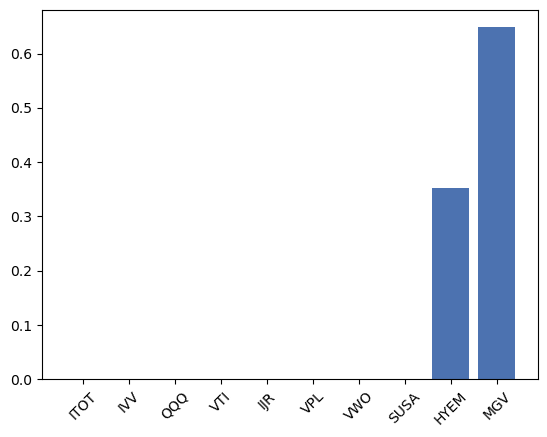

In [180]:
w = porfolio_weights(mu,S,0.1,plot = True)

## Backtest

el porcentaje final de ganancia es de: 94.20028935602458


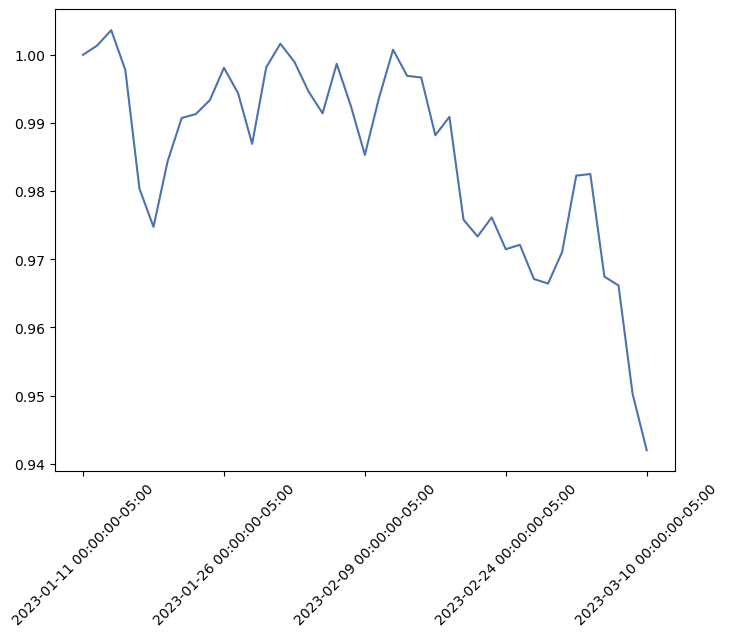

In [182]:
backtest(w,dataset_test)